## 1. Load asssociated libraries and data

In [1]:
# August, 2022, Evgenia Galytska (EG), IUP-UB.
#Application of PCMCI+. 
# Import libraries
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import stats
import iris
import os
import xarray as xr
%matplotlib inline
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

#import iris.analysis.cartography
from datetime import datetime as dt
from datetime import date, timedelta
import time
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict #
import matplotlib.patheffects as path_effects
import pickle
import sys
import copy

############################Start of EG_functions##########################################
# add the path with additional functions to simplify the calculations
#sys.path.append('/home/evgenia/tools/Arctic-midlat/Python_scripts/functions')
sys.path.append('/home/evgenia/tools/v3/Arctic-midlat/Python_scripts/functions/')

from functions_support import toYearFraction
from read_nc_files import load_1nc
from read_data_from_ESMValTool import read_Arctic_vars,read_Arctic_vars_noqbo_tas, read_model_data, read_model_data_noqbo_allt, read_siconca
from detrending import detrending
#from plot_1timeseries import plot_timeseries as pt
#from CMIP6_manipulations import colors_for_models 
#colors = colors_for_models ()
############################EG_functions##########################################

max_timelag = 5
masking_list = ["DJF"]#, "DJF", "JFM"]

pc_alpha_list = [ 0.01, 0.02]#, 0.05]

today = dt.now()
#create new directory based on date of the run
#base_folder = "/media/egalytska/Data_storage/tools/Arctic-midlat/output/PCMCI_plus/"
base_folder = "/home/evgenia/tools/v3/Arctic-midlat/output/PCMCI_plus/"

os.makedirs (base_folder + "dicts_from_PCMCIplus/" + today.strftime("%d%m%Y")+ "/", exist_ok=True)
os.makedirs (base_folder + "txt/" + today.strftime("%d%m%Y")+ "/", exist_ok=True)

for masking in masking_list:
    for pc_element in pc_alpha_list:
        os.makedirs (base_folder + "CN/" + today.strftime('%d%m%Y')+ '/' + masking + '/' + str(pc_element), exist_ok=True)
        os.makedirs (base_folder + "Summary_plots/" + today.strftime('%d%m%Y')+ '/' + masking + '/' + str(pc_element), exist_ok=True)

        
        
#os.makedirs("/home/evgenia/tools/Arctic-midlat/output/PCMCI_plus/actors/" + today.strftime('%d%m%Y')+ "/OBS/", exist_ok=True)
#os.makedirs("/home/evgenia/tools/Arctic-midlat/output/PCMCI_plus/dictionaries/" + today.strftime('%d%m%Y')+ "/OBS/", exist_ok=True)

/home/evgenia/anaconda3/envs/tigramite_april/lib/python3.9/site-packages/tigramite-5.0.1.7-py3.9.egg/tigramite/plotting.py:26: UserWarning: [Errno 2] No such file or directory: '/home/evgenia/anaconda3/envs/tigramite_april/lib/python3.9/site-packages/tigramite-5.0.1.7-py3.9.egg/tigramite/../versions.py'
  warnings.warn(str(e))
/home/evgenia/anaconda3/envs/tigramite_april/lib/python3.9/site-packages/tigramite-5.0.1.7-py3.9.egg/tigramite/independence_tests/gpdc.py:27: UserWarning: [Errno 2] No such file or directory: '/home/evgenia/anaconda3/envs/tigramite_april/lib/python3.9/site-packages/tigramite-5.0.1.7-py3.9.egg/tigramite/independence_tests/../../versions.py'
  warnings.warn(str(e))
/home/evgenia/anaconda3/envs/tigramite_april/lib/python3.9/site-packages/tigramite-5.0.1.7-py3.9.egg/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'torch'
  warnings.warn(str(e))


In [2]:

#var_names = ['PV', 'TAS', 'vflux', 'Sib-SLP', 'Ural-SLP','Aleut-SLP', 'NAO', 'QBO', 'ENSO', 'U', 'BK-SIC', 'Ok-SIC']
model_names = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CanESM5', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3',
              'EC-Earth3-Veg',  'EC-Earth3-Veg-LR',  'GFDL-CM4', 'GFDL-ESM4',  'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 
              'MIROC6','MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']
all_exp = model_names[:]
all_exp.insert(0, 'OBS')
#all_exp = ['OBS', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'CanESM5', 'CMCC-CM2-SR5', 'CMCC-ESM2', 'EC-Earth3',
#              'EC-Earth3-Veg',  'EC-Earth3-Veg-LR',  'GFDL-CM4', 'GFDL-ESM4',  'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 
#              'MIROC6','MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0']

path = '~/levante/work/bd0854/b380971/output/test_my_diagnostic/recipe_Arctic_telecon_develop_step_by_step_levante_20220615_132542/work/diagnostic_general/rename/'
path_cvdp  = '~/levante/work/bd0854/b380971/output/test_my_diagnostic/recipe_Arctic_telecon_era5_cvdp_20220614_154900/work/diagnostic_cvdp/cvdp/'

## 2. Load Arctic actors
### Observations

In [3]:
data_era5 = load_1nc(path, 'ERA5.nc')
pv, tas, tas_b, tas_s, sib, ural, aleut, zon_wind, vflux, time = read_Arctic_vars_noqbo_tas (data_era5)
time_new = pd.to_datetime(time, format='%m/%d/%Y')
month =  time_new.month
sic = load_1nc(path, 'HadISST.nc')
sic_BK = sic.BK_sic.data
sic_Ok = sic.Ok_sic.data
cvdp = xr.open_dataset (path_cvdp + 'native6.cvdp_data.1979-2019.nc', decode_times=False)
nao = cvdp.nao_timeseries_mon.data[:len (sic_BK)]
enso = cvdp.nino34.data[:len (sic_BK)]

var_names = ['PV', 'TAS', 'vflux', 'Sib-SLP', 'Ural-SLP','Aleut-SLP', 'NAO', 'U', 'BK-SIC', 'Ok-SIC']
list_of_vals = [pv, tas, vflux , sib, ural, aleut, nao[:len (pv)], zon_wind, sic_BK, sic_Ok]
#Create a dictionary here with OBS
dictionary = {"OBS": {var_names[0]: list_of_vals[0]}}
for i in range (1, len (var_names)): 
#    print (i, var_names[i])
    dictionary["OBS"].update ({var_names[i]: list_of_vals[i]})

In [4]:
#Some additional small calculations to convert time information into year fraction
#create an empty list
date_upd  = list ()
for i in range (0, len (time_new)):
    # add each converted value into list
    date_upd.append(toYearFraction(time_new[i]))
#convert list into array
year_fraction = np.asarray (date_upd)


## CMIP6 Models

In [5]:
# Read data from the models and update the dictionary
for m in range (0, len (model_names)):
    #open general files
    data_models = load_1nc(path, model_names[m] + '.nc')
    #open cvdp files
    data_models_cvdp = xr.open_dataset (path_cvdp + 'CMIP6_' + model_names[m] + '.cvdp_data.1979-2019.nc', decode_times=False)
    nao_m = data_models_cvdp.nao_timeseries_mon.data
    enso_m = data_models_cvdp.nino34.data
    pv_m, tas_m, tas_b_m, tas_s_m, sib_m, ural_m, aleut_m, zon_wind_m, vflux_m, sic_BK_m, sic_Ok_m, time_m = read_model_data_noqbo_allt (data_models)
    list_of_model_vals = [pv_m, tas_m, vflux_m ,sib_m, ural_m, aleut_m,nao_m[:len (pv_m)], zon_wind_m, sic_BK_m, sic_Ok_m]

    dictionary[model_names[m]] = {var_names[0]: list_of_model_vals[0]}
    for i in range (1, len (list_of_model_vals)): 
        dictionary[model_names[m]].update ({var_names[i]: list_of_model_vals[i]}) #= {"BK-SIC": sic_BK_m}
print ('Observational and modelled data is saved into dictionary')

Observational and modelled data is saved into dictionary


## 3. Prepare data for Tigramite
#### Detrend each actor

In [6]:
for key in dictionary.keys ():
    for var in var_names:
#        print ( 'detrended', key, var)
        dictionary[key][var]          = detrending (dictionary[key][var])

#### Construct an array from detrended data for Causal Discovery

In [7]:
data= np.zeros(( len (dictionary.keys ()), len (time_new),  len (var_names)))
for i,val in enumerate (dictionary.keys ()):
    for j, val2 in enumerate (var_names):
        data[i, :, j] =  dictionary[val][val2]
M, T, N = data.shape
print("# Models   Data Length   No of Actors")
print( '   ',  M, '     ' ,T, '           ', N)  

# Models   Data Length   No of Actors
    20       492             10


## 4. Calculate Causal Graph for each data source. 

#### This routine can be used to reproduce Fig. 3 of Galytska et al., 2022

DJF
Applying mask DJF
Calculating pc_alpha =  0.01


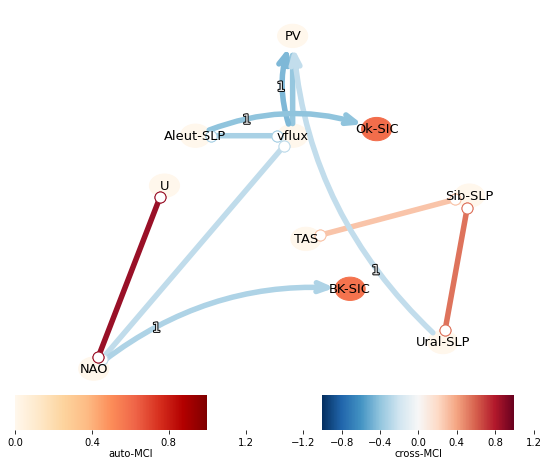

Calculating pc_alpha =  0.02


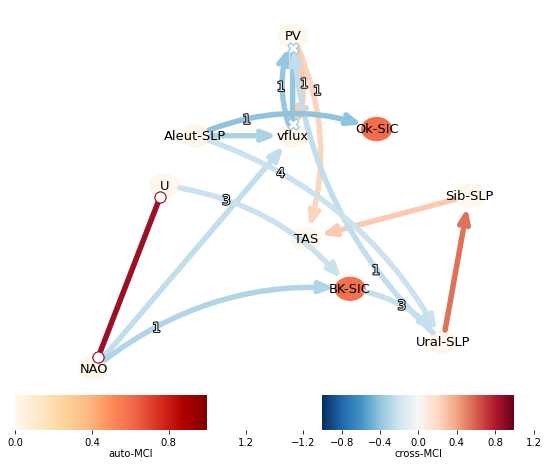

Calculating pc_alpha =  0.01


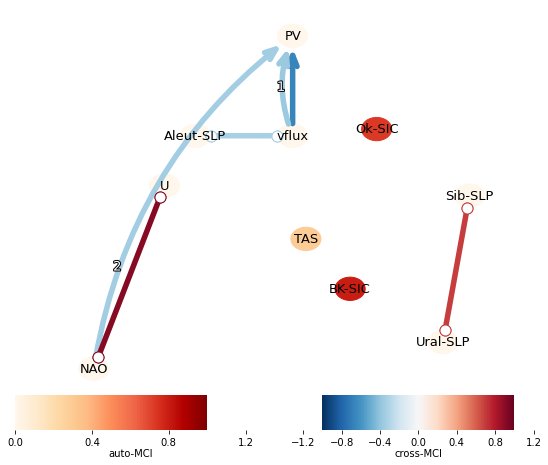

Calculating pc_alpha =  0.02


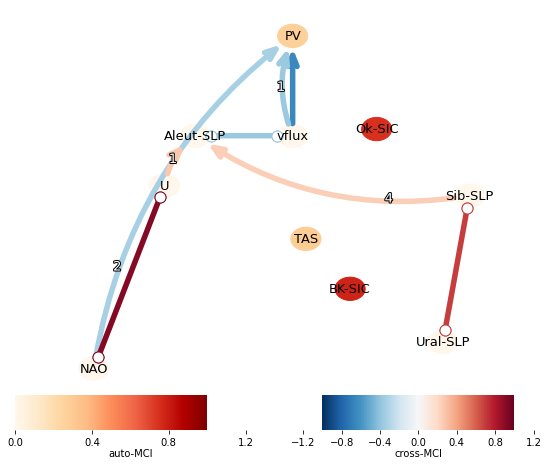

Calculating pc_alpha =  0.01


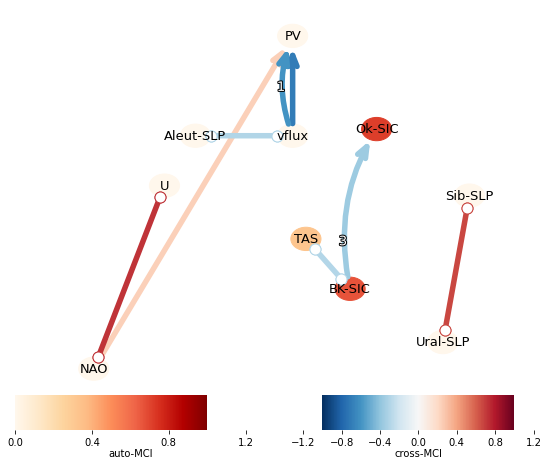

Calculating pc_alpha =  0.02


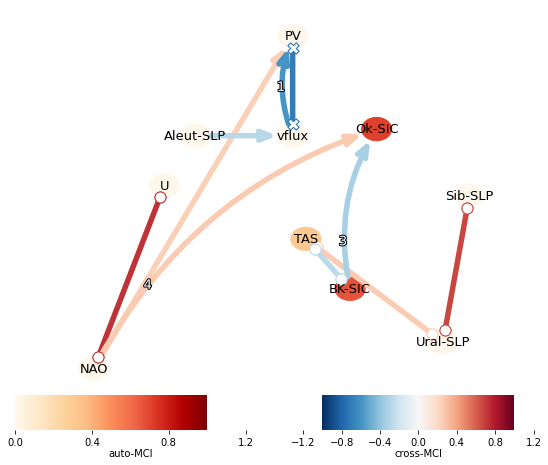

Calculating pc_alpha =  0.01


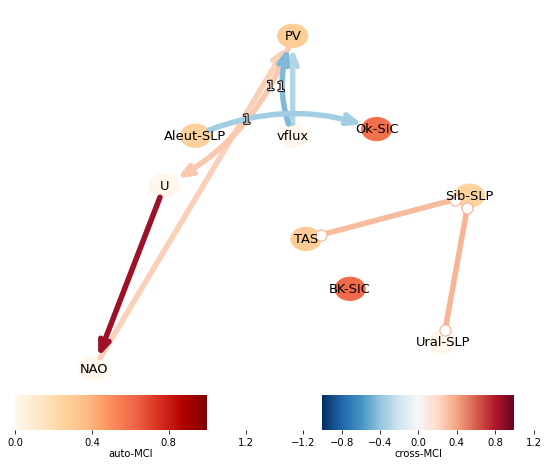

Calculating pc_alpha =  0.02


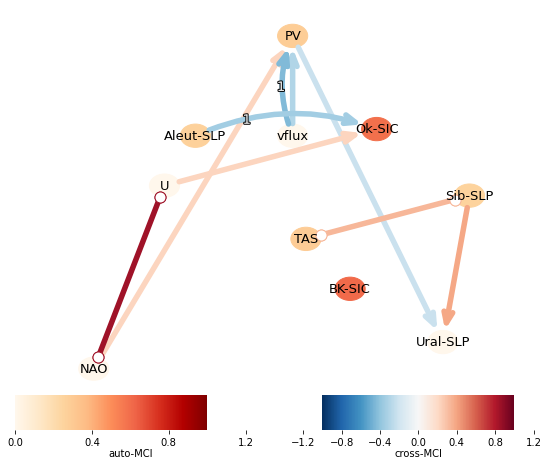

Calculating pc_alpha =  0.01


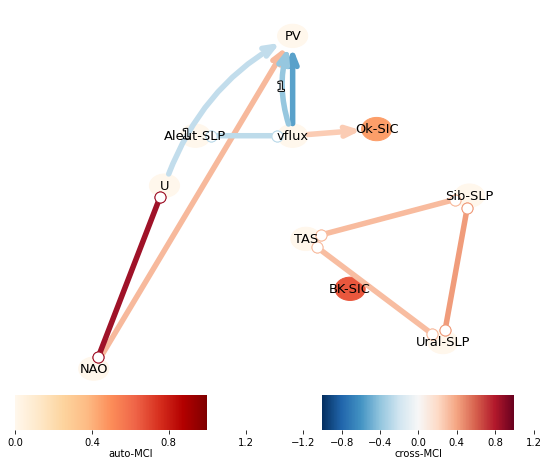

Calculating pc_alpha =  0.02


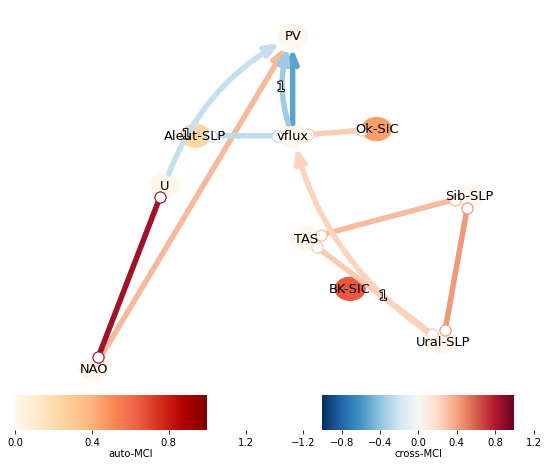

Calculating pc_alpha =  0.01


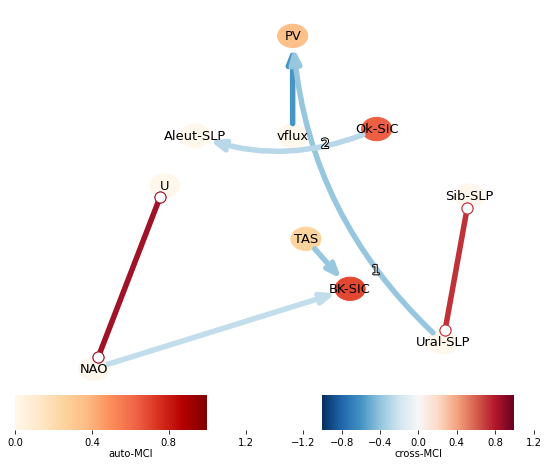

Calculating pc_alpha =  0.02


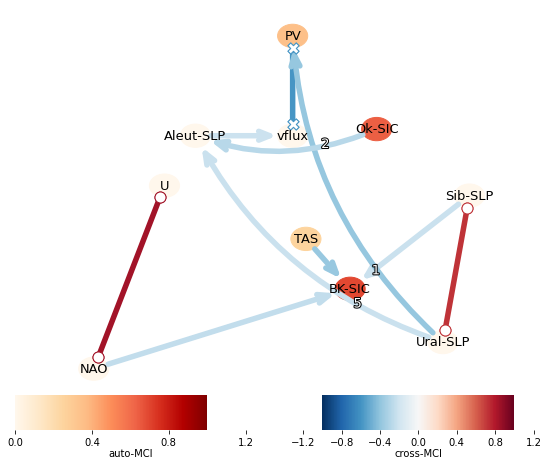

Calculating pc_alpha =  0.01


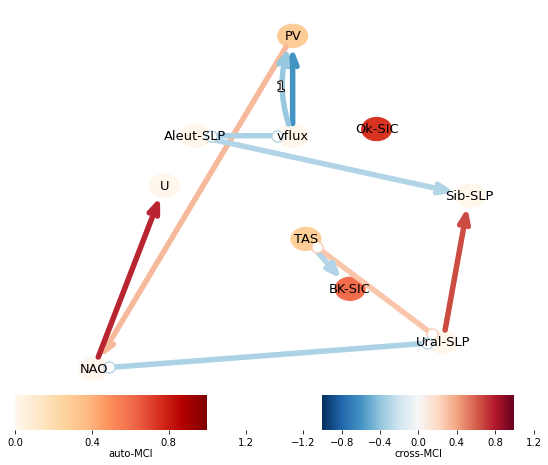

Calculating pc_alpha =  0.02


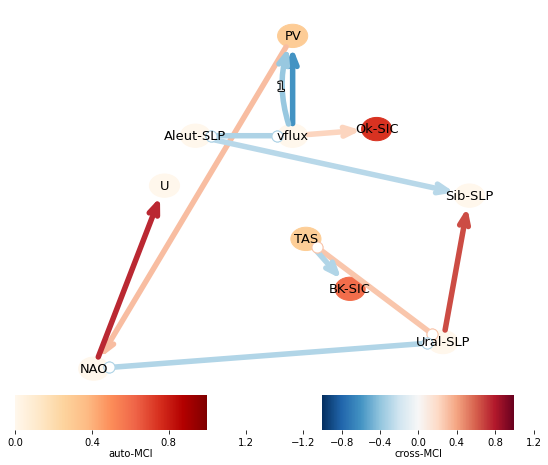

Calculating pc_alpha =  0.01


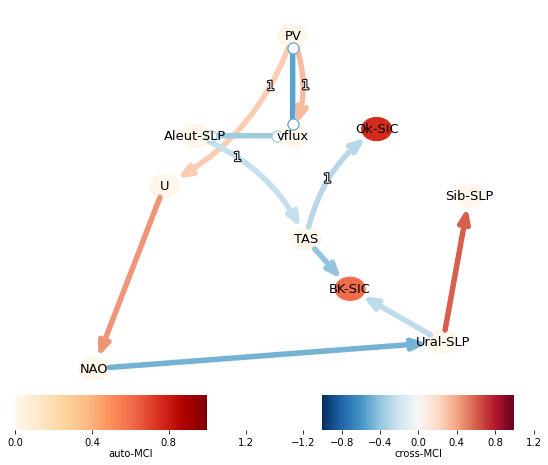

Calculating pc_alpha =  0.02


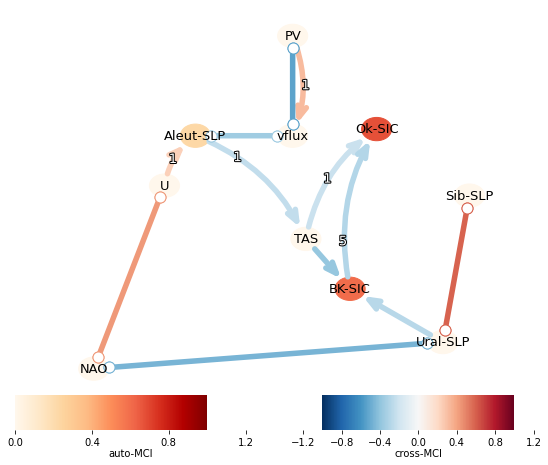

Calculating pc_alpha =  0.01


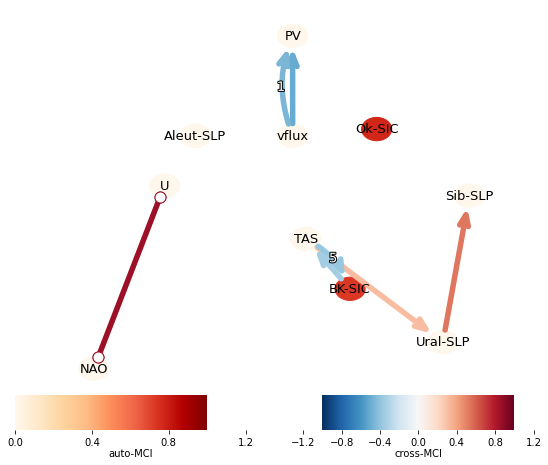

Calculating pc_alpha =  0.02


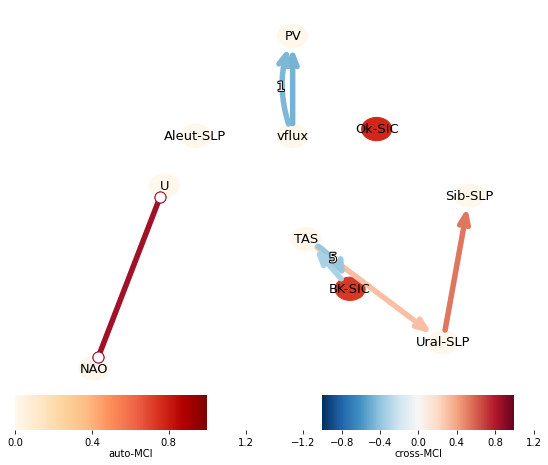

Calculating pc_alpha =  0.01


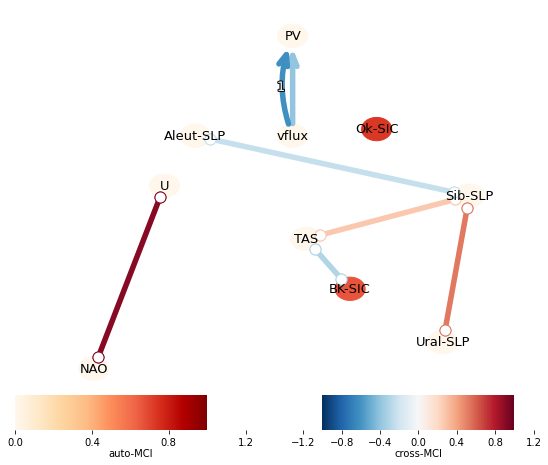

Calculating pc_alpha =  0.02


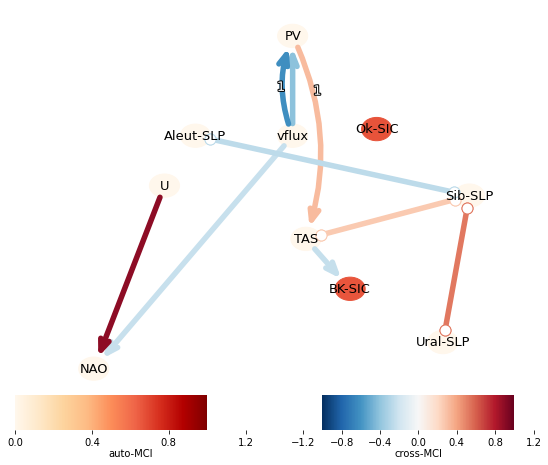

Calculating pc_alpha =  0.01


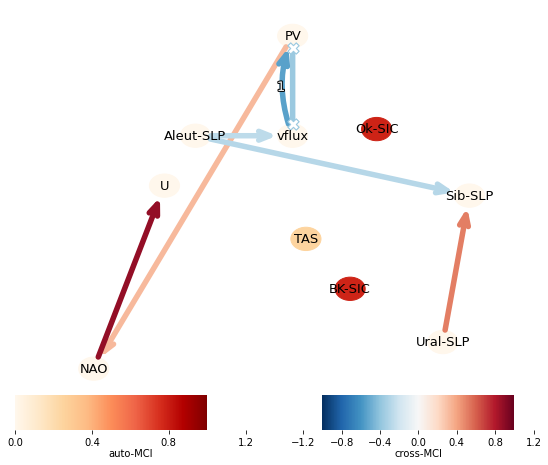

Calculating pc_alpha =  0.02


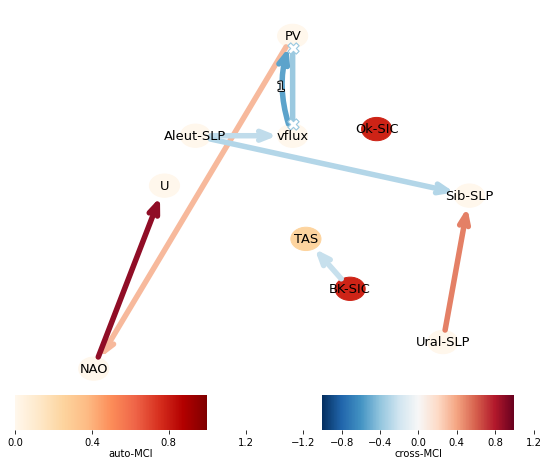

Calculating pc_alpha =  0.01


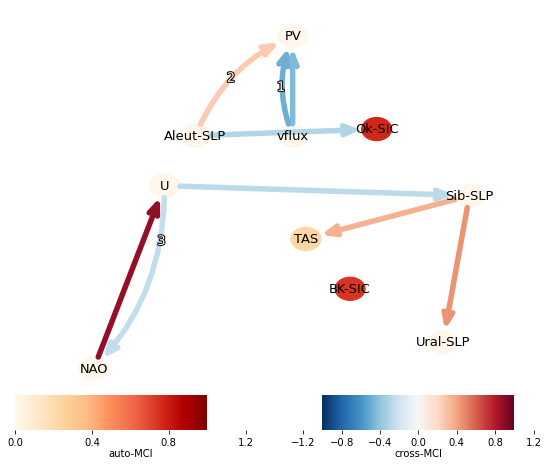

Calculating pc_alpha =  0.02


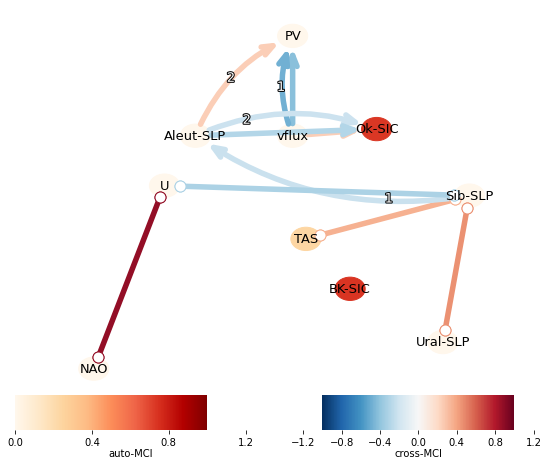

Calculating pc_alpha =  0.01


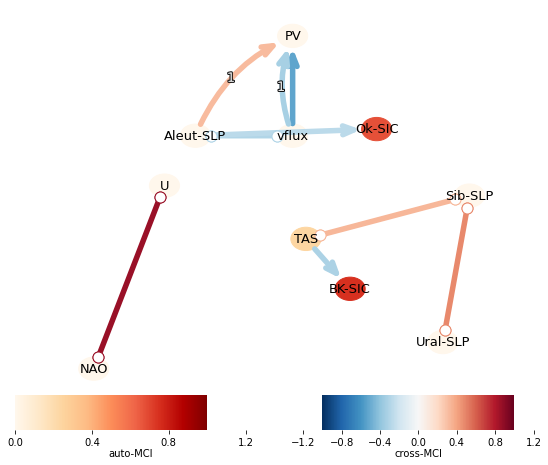

Calculating pc_alpha =  0.02


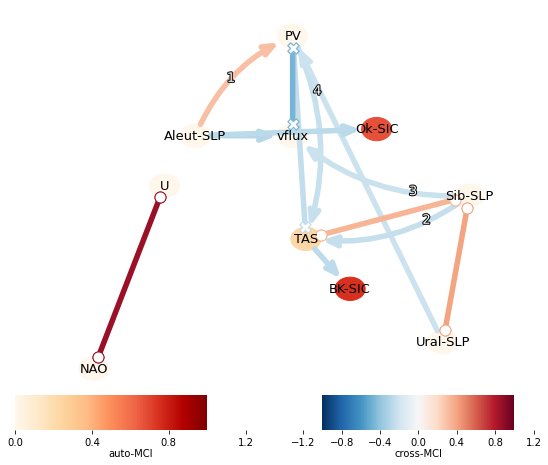

Calculating pc_alpha =  0.01


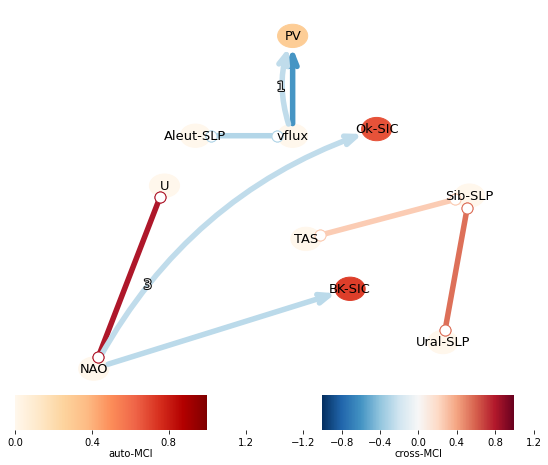

Calculating pc_alpha =  0.02


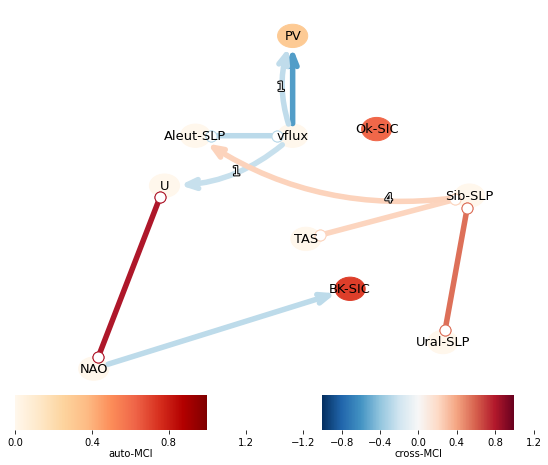

Calculating pc_alpha =  0.01


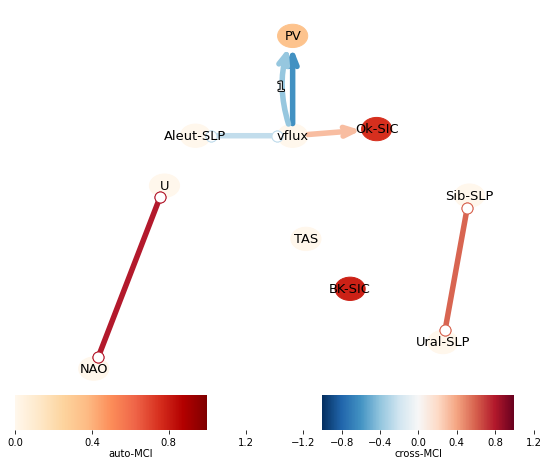

Calculating pc_alpha =  0.02


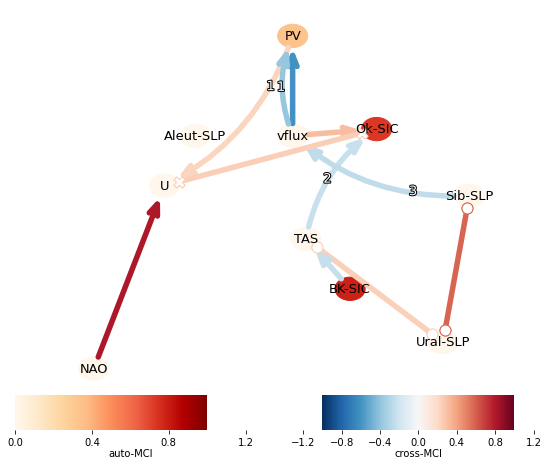

Calculating pc_alpha =  0.01


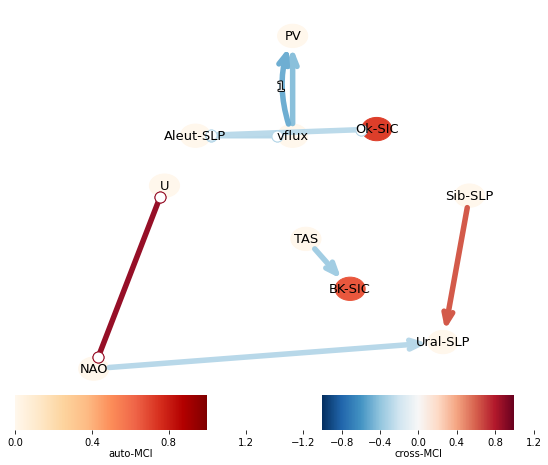

Calculating pc_alpha =  0.02


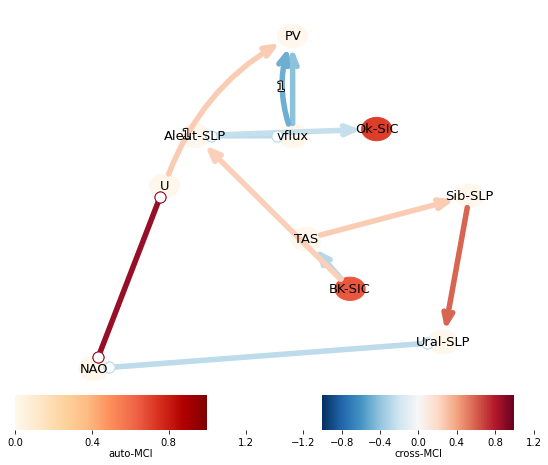

Calculating pc_alpha =  0.01


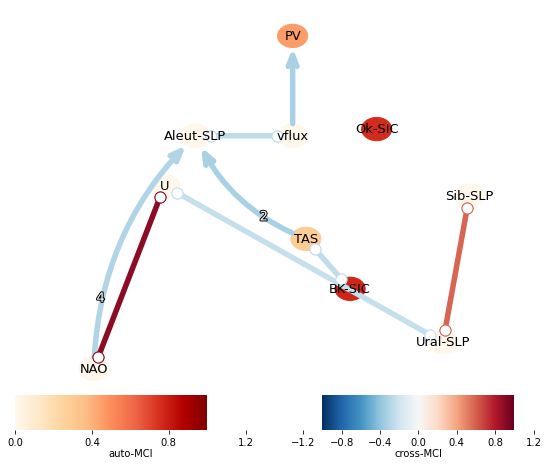

Calculating pc_alpha =  0.02


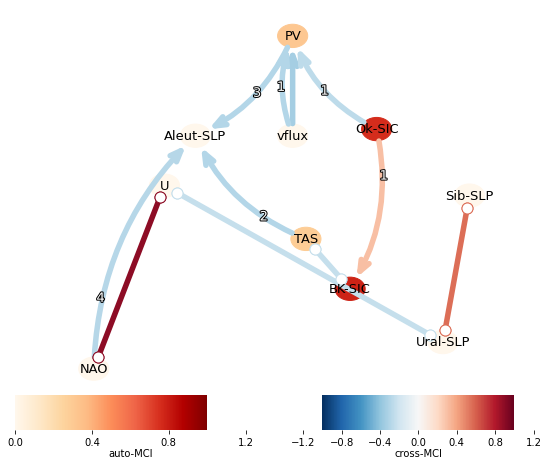

Calculating pc_alpha =  0.01


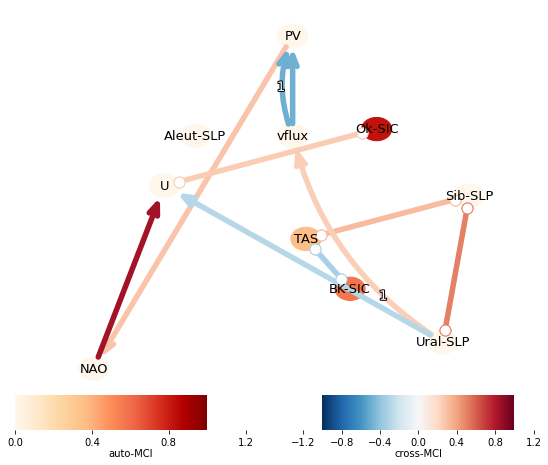

Calculating pc_alpha =  0.02


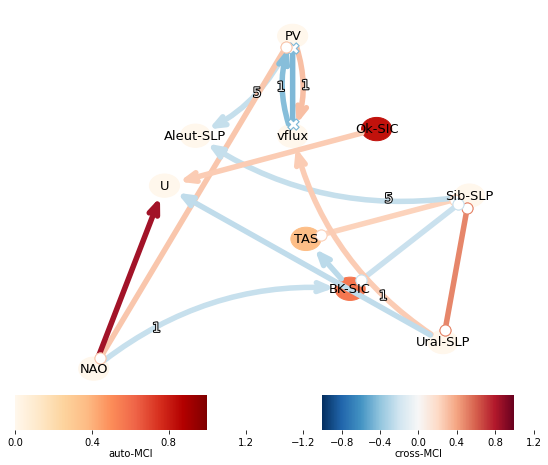

Calculating pc_alpha =  0.01


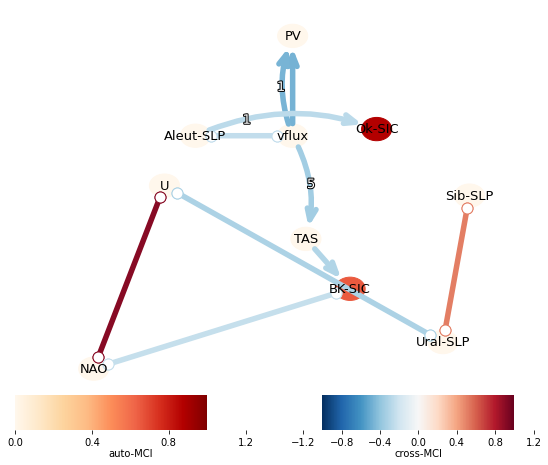

Calculating pc_alpha =  0.02


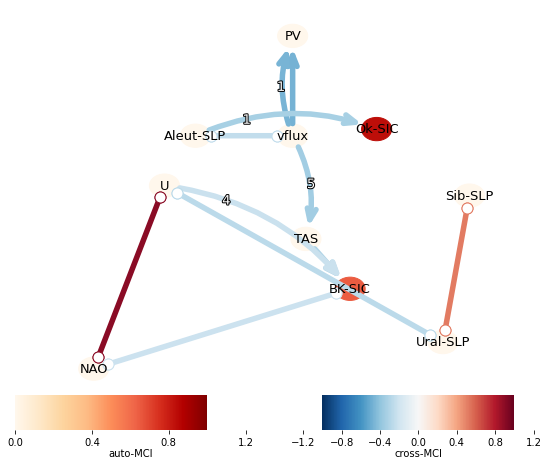

Calculating pc_alpha =  0.01


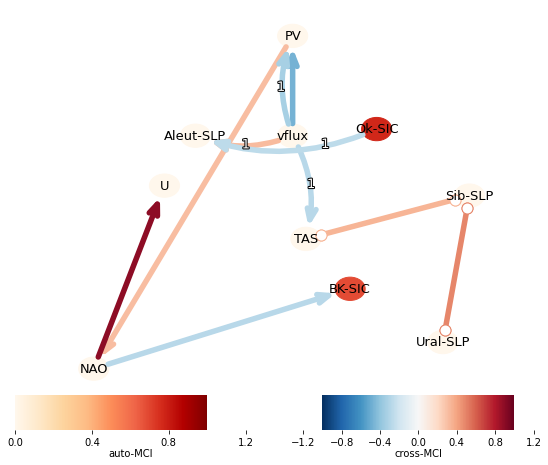

Calculating pc_alpha =  0.02


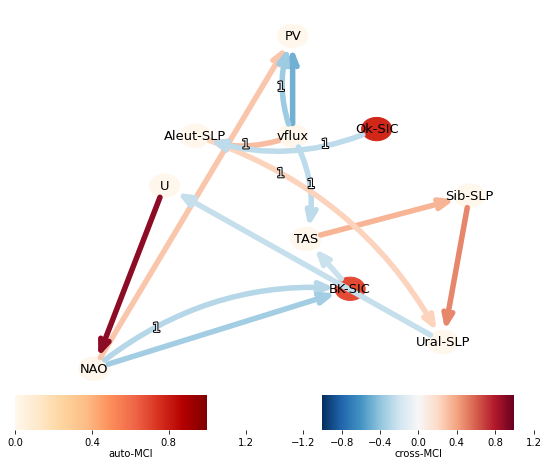

In [8]:
#Do you want to plot original causal graph from each data sourse?
plot_Causal_Graphs = True
#Do you want to save the dictionary with from the application of Causal Discovery?
save_orig_dict = True


dict_networks= {}
for masking in masking_list:
    print (masking)
    data_mask = np.zeros(data.shape)
    if masking == "OND":
        print ('Applying mask OND')
        data_masking= np.where(np.logical_and(month > 0, month < 10), 1,0) #!1 stands for data, which will be masked
    elif masking == "DJF":
        print ('Applying mask DJF')
        data_masking= np.where(np.logical_and(month > 2, month < 12), 1,0) #!1 stands for data, which will be masked
    elif masking == "JFM":
        print ('Applying mask JFM')
        data_masking= np.where(np.logical_and(month > 3, month < 13), 1,0) #!1 stands for data, which will be masked    
    for m in range (0, M):
        for n in range (0, N):
            data_mask[m, :, n] = data_masking
    for i,key in enumerate (dictionary.keys ()):
        for pc_element in pc_alpha_list:
            print ("Calculating pc_alpha = ", pc_element)

            dict_networks.setdefault(key,{})
#                dict_networks[key].setdefault ('season', {})
            dict_networks[key].setdefault (masking, {})
            dict_networks[key][masking].setdefault (pc_element, {})

            dataframe = pp.DataFrame(data[i, :, :], datatime = year_fraction, var_names = var_names, mask = data_mask[i, :, :])
            dataframe.mask = (dataframe.mask == True) # true vals will be masked
            parcorr = ParCorr(significance='analytic', mask_type = 'y')
            pcmci = PCMCI(dataframe=dataframe, cond_ind_test=parcorr, verbosity=0)
            results = pcmci.run_pcmciplus(tau_max=max_timelag, pc_alpha=pc_element)
            q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=max_timelag, fdr_method='fdr_bh')
            
            dict_networks[key][masking][pc_element].setdefault ('results', results)
            
            if plot_Causal_Graphs: 
            # Plotting Causal Graphs
                tp.plot_graph(
                                val_matrix=results['val_matrix'],
                               graph=results['graph'],
                               var_names=var_names,
                                figsize = (8,8),
                               #              var_names =  PV,  TAS, vflux, Sib, Ural, Aleut, NAO,    U, BK-SIC, Ok-SIC]####
           #
                                node_pos = {'x': np.array([ 6.0,  6.3,       6.0,      10,       9.4 ,        3.8 ,      1.5,    3.1,   7.3,   7.9 ]),
                                            'y': np.array([ 10.0, 3.9,      7.0,      5.2,       0.8,        7.0,       0.0,    5.5,   2.4,   7.2])},
                               node_size=0.7,       
                               link_colorbar_label='cross-MCI',
                               node_colorbar_label='auto-MCI', 
                               node_label_size = 13,
                               link_label_fontsize = 13, 
                               arrow_linewidth = 11, 
                       save_name = base_folder + "CN/" + today.strftime('%d%m%Y') + '/'+ masking + '/' + str(pc_element) + '/'+ key + '_PCMCIplus_pcalpha_'+str (pc_element)+"_" +str(len(var_names))+'actors_'+masking+'.png'),
                plt.show()
                
            if save_orig_dict:
                #save complete dictionary 
                np.save(base_folder + "dicts_from_PCMCIplus/" + today.strftime('%d%m%Y') + '/'+ '1causal_links_historical_'+ str(len(var_names))+'actors_for_f1.npy', dict_networks)

#save only graph data from OBS 
for masking in masking_list:
    for pc_element in pc_alpha_list:
         with open(base_folder +'dicts_from_PCMCIplus/' + today.strftime('%d%m%Y') + '/' + '2OBS_results_links_1979-2019_'+masking+ '_'+str(pc_element)+ '_'+ str(len(var_names))+'actors.pickle', 'wb') as handle:
            pickle.dump(dict_networks["OBS"][masking][pc_element]["results"]["graph"], handle, protocol=pickle.HIGHEST_PROTOCOL)


## 5. Prepare data for Summary plot 
#### Can be used to reproduce Fig. 5 of Galytska et al., 2022

In [9]:
#Here sort oroginal data from the application of causal Discovery 
#into dictionary with correlation/autocorrelation values

#Do you want to save the correlation/autocorrelation data into a new dictionary? True -Yes, False - No.
save_corr_autocorr_data = True

# Do some fun!
dict_tigramite = {}

for key in dict_networks.keys ():
    dict_tigramite.setdefault(key,{})
    for masking in masking_list:
        dict_tigramite[key].setdefault (masking, {})
        for pc_element in pc_alpha_list:
            dict_tigramite[key][masking].setdefault (pc_element, {})
            dict_tigramite[key][masking][pc_element].setdefault('correlation', {})
            dict_tigramite[key][masking][pc_element].setdefault('autocorrelation', {})
            #for the autocorrelation
            test2_list = list ()
            #for the correlation
            vars1 = list ()
            lag_list = list ()
            vvv = list ()
            for i in range (0, len (var_names)):
                for j in range (0, len (var_names)): 
                    for k in range (0, (max_timelag +1)):
                        #If the link is detected: 
                        if dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] != "":
                            # Replace unoriented and conflicted graphs with one symbol
                            if k==0: 
                                if dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == 'o-o' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == 'x-x' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == '-->' or \
                                dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] == '<--':
                                    dict_networks[key][masking][pc_element]['results']['graph'][i,j,k] = '--'
                            
                            #First check the autocorrelation:
                            if var_names[i] == var_names[j]:
                                auto = 'autocorrelation'
                                test2_list.append ([var_names[i], k, dict_networks[key][masking][pc_element]['results']['val_matrix'][i,j,k]])
                                dict_tigramite[key][masking][pc_element][auto] = test2_list
                            #Now check instantaneous and causal links
                            else:
                                corr = 'correlation'
                                #vars1.append (var_names[i] +  symbol + var_names[j])
                               
                                
                                
                                vars1.append (var_names[i] + ' '+dict_networks[key][masking][pc_element]['results']['graph'][i,j,k]+ ' '+ var_names[j])

                                lag_list.append (k)
                                vvv.append (dict_networks[key][masking][pc_element]['results']['val_matrix'][i,j,k])
                                # Remove duplicates e.g.  PDO--NAO and NAO-- PDO
                                s = list ()
                                skipped = list ()
                                for ind, var in enumerate (vvv):
                                    if var not in s:
                                        s.append (var)
                                    else:
                                        skipped.append (ind)
                                for index in sorted(skipped, reverse=True):
        #                            print (index)
                                    del vvv[index], vars1[index], lag_list[index]

                                testing = list ()
                                for idn in range (0, len (vvv)):
                                    testing.append ([vars1[idn], lag_list[idn],vvv [idn] ])
                                dict_tigramite[key][masking][pc_element][corr] = testing

if save_corr_autocorr_data: 
    np.save(base_folder + '/dicts_from_PCMCIplus/' + today.strftime('%d%m%Y') + '/'+ '3sorted_corr_autocorr_historical_' + str(len(var_names))+'actors.npy', dict_tigramite)                           

In [10]:
# Check all possible links from all data sources 
all_possible_links = list ()
skipped = list ()
for key in dict_tigramite.keys ():
    for masking in masking_list:
        for pc_element in pc_alpha_list:
            for link in dict_tigramite[key][masking][pc_element]['correlation']:
                if link[0] not in all_possible_links:
                    all_possible_links.append (link[0])
                else:
                    skipped.append (link[0])
#Sort alphabetically
sorted_links = sorted (all_possible_links)

In [11]:
print ('Check the most frequent links (not sorted)')
(({i:skipped.count(i) for i in skipped}))

Check the most frequent links (not sorted)


{'PV -- vflux': 39,
 'TAS -- Sib-SLP': 18,
 'vflux --> PV': 33,
 'vflux -- Aleut-SLP': 24,
 'vflux -- NAO': 2,
 'Sib-SLP -- Ural-SLP': 39,
 'Ural-SLP --> PV': 3,
 'Aleut-SLP --> Ok-SIC': 6,
 'NAO -- U': 39,
 'NAO --> BK-SIC': 3,
 'NAO --> PV': 1,
 'PV -- NAO': 13,
 'TAS -- BK-SIC': 24,
 'BK-SIC --> Ok-SIC': 2,
 'TAS -- Ural-SLP': 7,
 'vflux -- Ok-SIC': 5,
 'U --> PV': 2,
 'NAO -- BK-SIC': 7,
 'Ok-SIC --> Aleut-SLP': 3,
 'Sib-SLP -- Aleut-SLP': 5,
 'Ural-SLP -- NAO': 5,
 'PV --> vflux': 3,
 'PV --> U': 2,
 'TAS --> Ok-SIC': 2,
 'Ural-SLP -- BK-SIC': 1,
 'Aleut-SLP --> TAS': 1,
 'U --> Aleut-SLP': 1,
 'TAS --> BK-SIC': 1,
 'PV --> TAS': 2,
 'Sib-SLP --> Aleut-SLP': 3,
 'Sib-SLP -- U': 1,
 'Aleut-SLP --> PV': 3,
 'Aleut-SLP -- Ok-SIC': 5,
 'PV -- Ural-SLP': 1,
 'NAO --> Ok-SIC': 1,
 'Sib-SLP --> vflux': 1,
 'U -- Ok-SIC': 3,
 'TAS --> Aleut-SLP': 1,
 'Ural-SLP -- U': 6,
 'NAO --> Aleut-SLP': 1,
 'Ural-SLP --> vflux': 2,
 'PV --> Aleut-SLP': 1,
 'Sib-SLP -- BK-SIC': 1,
 'vflux --> TAS': 3,

In [12]:
interested_in_correlation = True
interested_in_autocorrelation = False

correlation_dict = {}
autocorrelation_dict = {}

if interested_in_correlation: 
    lll = list ()
    for key in dict_tigramite.keys ():
        correlation_dict.setdefault (key, {})
        for masking in masking_list:
            correlation_dict[key].setdefault(masking, {})
            for pc_element in pc_alpha_list:
                correlation_dict[key][masking].setdefault (pc_element, {})
                tr = defaultdict(list) # use defaultdictionary for a trick
                for a, b, c in dict_tigramite[key][masking][pc_element]['correlation']: 
                    tr[a].append ([b,c])
                lll.append (tr)
                correlation_dict[key][masking][pc_element].setdefault ('plotting', lll)

                
#Not yet programmed                
if interested_in_autocorrelation:
    
    lll_auto = list ()
    for key in dict_tigramite.keys ():
        autocorrelation_dict.setdefault (key, {})
        for masking in masking_list:
            autocorrelation_dict[key].setdefault(masking, {})
            for pc_element in pc_alpha_list:
                
                autocorrelation_dict[key][masking].setdefault (pc_element, {})
                tr_auto = defaultdict(list) # use defaultdictionary for a trick
                for a, b, c in dict_tigramite[key][masking][pc_element]['autocorrelation']: 
                    tr_auto[a].append ([b,c])
                lll_auto.append (tr_auto)
                autocorrelation_dict[key][masking][pc_element].setdefault ('plotting', lll)
    

In [13]:
# Use modified_links to change the order of connections in the Summary plot, Fig. 5 Galytska et al.
modified_links = [ 'TAS -- BK-SIC', 'TAS -- Sib-SLP', 'TAS -- Ural-SLP', 'TAS --> Ok-SIC', 
                    'Sib-SLP -- Ural-SLP', 'Sib-SLP -- Aleut-SLP', 
                   'Ural-SLP --> PV','Ural-SLP -- NAO', 'Ural-SLP -- U', 
                  'BK-SIC --> Ok-SIC', 
                 'NAO -- BK-SIC', 'NAO --> BK-SIC', 'NAO -- U', 'NAO --> Aleut-SLP', 'NAO --> Ok-SIC',
                  'PV -- NAO', 'PV -- vflux', 'PV --> vflux',  
                  'vflux --> PV', 'vflux -- Aleut-SLP', 'vflux --> TAS', 'vflux -- NAO',
                  
                   'Aleut-SLP --> Ok-SIC', 'Aleut-SLP -- Ok-SIC', 'Aleut-SLP --> PV',
                  'U -- Ok-SIC', 
                  'Ural-SLP -- BK-SIC', 
                  'TAS --> Aleut-SLP', 
]

MASK:  DJF PC_alpha: 0.01
MASK:  DJF PC_alpha: 0.02


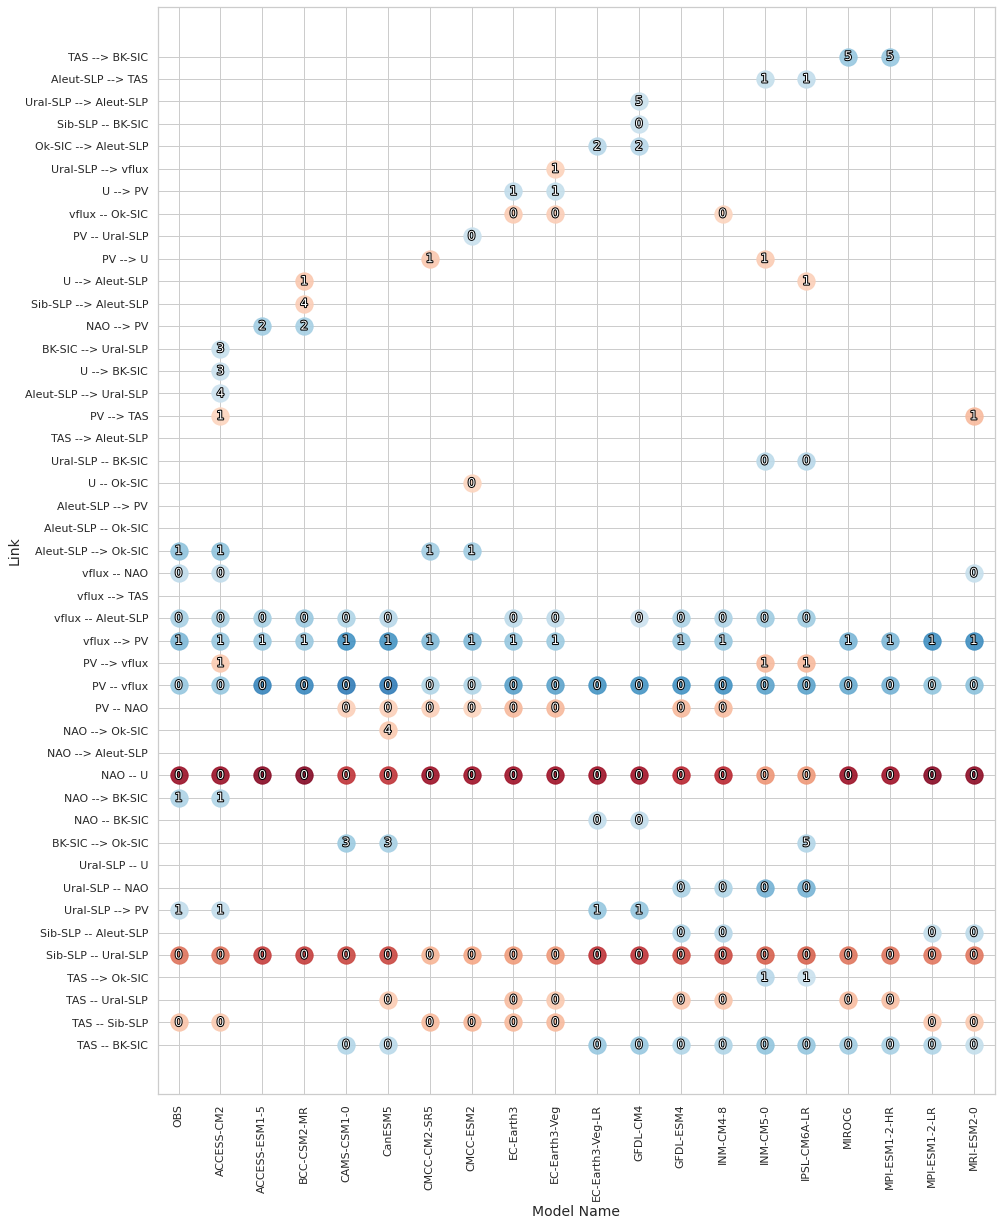

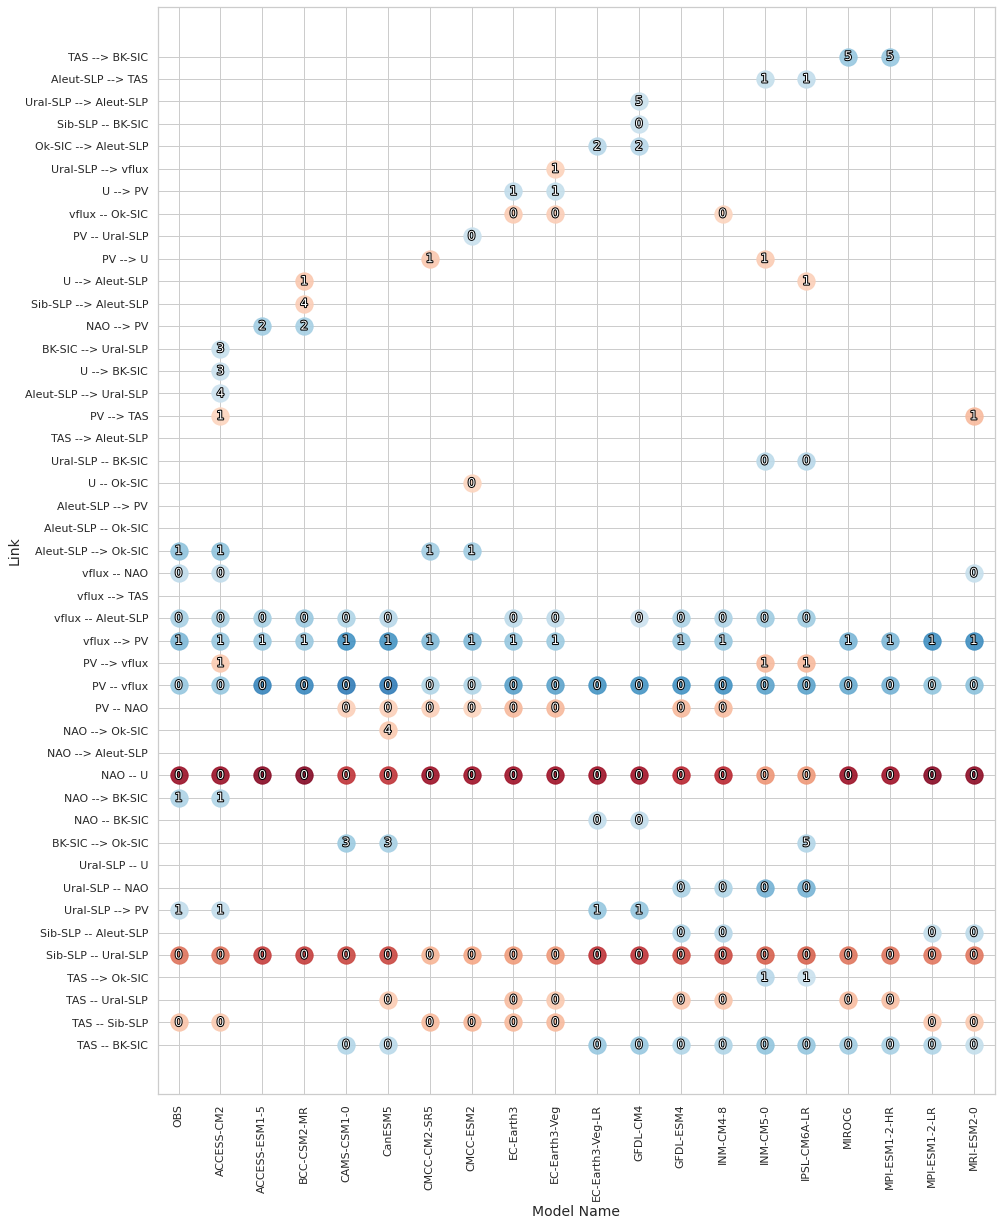

In [22]:
sns.set(style="whitegrid")

 #



for masking in masking_list:
    for pc_element in pc_alpha_list:
    
        fig, ax = plt.subplots(figsize = (15, 20))
        print ("MASK: ", masking, 'PC_alpha:', pc_element)
        mycmap = matplotlib.cm.get_cmap('RdBu_r')
        ax.set_xlim([-0.5, len(dict_tigramite.keys ())-0.5])
        ax.set_xticks(np.linspace(0, len(dict_tigramite.keys ())-1, len(dict_tigramite.keys ())))
        ax.set_xticklabels(dict_tigramite.keys (),fontsize=11, rotation=90)
        ax.set_xlabel('Model Name',fontsize=14) #, fontweight='bold')
        #ax.set_ylim([-1, len(sorted_links)+ 0.05])
        #ax.set_yticks(np.linspace(0, len(title)-1, len(title)))
        #ax.set_yticklabels(title, fontsize=9)
        ax.set_ylabel('Link',fontsize=14)#, fontweight='bold')

        plt.scatter (np.zeros(len (modified_links)),modified_links, color = 'white',s = 0)

        for n_model, key in enumerate (correlation_dict.keys ()): 
    

            tmp_var =  correlation_dict[key][masking][pc_element]['plotting'][n_model]
    
            for idx, variable in enumerate (list(tmp_var.keys())): 

    
#            for idx, variable in enumerate (list (lll[n_model].keys ())): 
                if len(list(tmp_var.values ())[idx]) > 1:
                    for idn,tt in enumerate (list(tmp_var.values ())[idx]):
                        # position (pos) of nodes is needed to define if you have several links between the same actors.
                        pos = n_model + np.linspace (0, 0.3, len (list(tmp_var.values ())[idx])) 
                        pfc = plt.scatter(pos[idn], list (tmp_var.keys ())[idx], c=list(tmp_var.values ())[idx][idn][1], vmin=-1.0, vmax=1.0, marker="o",  alpha=0.9,  s = 300, cmap=mycmap)
                        text = plt.text(pos[idn], list (tmp_var.keys ())[idx], s=(list(tmp_var.values ())[idx][idn][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
                        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'), 
                                               path_effects.Normal()])  


                else: 
                    pfc = plt.scatter(key, variable, c=(list(tmp_var.values ())[idx][0][1]), vmin=-1.0, vmax=1.0, marker="o",  alpha=0.9, s = 300, cmap=mycmap)
                    text = plt.text(key, variable, s=(list(tmp_var.values ())[idx][0][0]), color='white',  verticalalignment='center', horizontalalignment='center') 
                    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()])   
        plt.savefig (base_folder + 'Summary_plots/' + today.strftime('%d%m%Y') + '/'+ masking + '/' + str (pc_element) + '/SUMMARY_presentation_1979-2019_'+masking + '_' + str (pc_element) + '.png', dpi= 120, bbox_inches = "tight")
                     

In [15]:
# The last routine is to count how many models reproduce identical to OBS link
# use this routine to get the numbers in hexagon in Fig.4, Galytska et al., 2022

In [16]:
#dict_networks_orig = copy.deepcopy(dict_networks)
fin_dict = {}
#symbols_list = ['o-o', 'x-x' , '-->', '<--']
symbols_list = ['--', '-->']

for masking in masking_list:
    fin_dict.setdefault(masking, {})
    for pc_element in pc_alpha_list:
        fin_dict[masking].setdefault(pc_element, {})

        fin_result_list = list()
        for idx, symbol in enumerate (symbols_list):
            
            link_matrix_list = list ()
            
            for key in dict_networks.keys ():
                t = np.zeros ((10,10, 6))
                for i in range (0, N):
                    for j in range (0, N): 
                        for k in range (0, (max_timelag +1)):
                            if dict_networks[key][masking][pc_element]['results']['graph'] [i,j,k] == symbol: 
                                t[i,j,k] = 1
                                dict_networks[key][masking][pc_element]['results'].setdefault ('val'+str(idx+1), t)

                            else:
                                t [i,j,k] = 0 
                                dict_networks[key][masking][pc_element]['results'].setdefault ('val'+str(idx+1), t)

                if key != "OBS": 
                    link_matrix=dict_networks[key][masking][pc_element]['results']['val'+str(idx+1)].astype(int)
                    link_matrix_list.append (link_matrix)
                    
                    
            link_matrix_obs = dict_networks["OBS"][masking][pc_element]['results']['val'+str(idx+1)]
           
            my_sum = np.sum(link_matrix_list, axis=0)    
            other_result = my_sum * link_matrix_obs.astype(int) # multiply by obs to show only those links, that are present at observations
            fin_result_list.append (other_result)  
        fin_dict[masking][pc_element].setdefault('count_symbol',np.sum (fin_result_list, axis = 0))
            

In [29]:
#save output in a .txt file
path_save_txt=base_folder + '/txt/'+ today.strftime('%d%m%Y') + '/'
# Save data in the file
for masking in masking_list:
    print ('--------------', masking, '--------------')
    for pc_element in pc_alpha_list:
        print ('-------------', pc_element, '-------------')
        filewr=path_save_txt+'obs_vs_models_'+str(masking) + str (pc_element)+ '.txt'
        fhand=open(filewr,'w+')

        for i in range (0, N):
            for j in range (0, N): 
                for k in range (0, (max_timelag +1)):

                    if fin_dict[masking][pc_element]['count_symbol'][i,j,k] > 0 and i!=j: 
        #                if var_names[i] == 'NAO' and var_names[j] == 'v-flux':
                        if var_names[i] !=var_names[j]:
                            print (var_names[i],   var_names[j], ', lag:', k,  ', #models', fin_dict[masking][pc_element]['count_symbol'][i,j,k])
                            fhand.write('{0:>10}{1:>10}{2:>3d}{3:4d}\n'.format (str (var_names[i]), str (var_names[j]), k, fin_dict[masking][pc_element]['count_symbol'][i,j,k]))                
        fhand.close() 

-------------- DJF --------------
------------- 0.01 -------------
PV vflux , lag: 0 , #models 19
TAS Sib-SLP , lag: 0 , #models 8
vflux PV , lag: 0 , #models 19
vflux PV , lag: 1 , #models 16
vflux Aleut-SLP , lag: 0 , #models 12
Sib-SLP TAS , lag: 0 , #models 8
Sib-SLP Ural-SLP , lag: 0 , #models 19
Ural-SLP PV , lag: 1 , #models 1
Ural-SLP Sib-SLP , lag: 0 , #models 19
Aleut-SLP vflux , lag: 0 , #models 12
Aleut-SLP Ok-SIC , lag: 1 , #models 2
NAO U , lag: 0 , #models 19
U NAO , lag: 0 , #models 19
------------- 0.02 -------------
PV TAS , lag: 1 , #models 1
PV vflux , lag: 0 , #models 19
PV vflux , lag: 1 , #models 2
TAS Sib-SLP , lag: 0 , #models 9
vflux PV , lag: 0 , #models 19
vflux PV , lag: 1 , #models 16
vflux Aleut-SLP , lag: 0 , #models 11
vflux NAO , lag: 0 , #models 1
Sib-SLP TAS , lag: 0 , #models 9
Sib-SLP Ural-SLP , lag: 0 , #models 19
Ural-SLP PV , lag: 1 , #models 1
Ural-SLP Sib-SLP , lag: 0 , #models 19
Aleut-SLP vflux , lag: 0 , #models 11
Aleut-SLP Ok-SIC , lag: 1